In [1]:
from astropy import constants as cste
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

## Numerical integration scheme

In [2]:
#--calculate the glf for the flux and the pressure over the all domain
def glf(N, F, P, i):
    #initialize/reset the glf lists
    glf_f, glf_p = [], []
    for j in range(0,n_cell):
            if i == 0 and j == 0:
                glf_f.append(0)
                glf_p.append(0)
            if i != 0 and j == 0:
                glf_f.append( (F[i - 1][n_cell - 1] + F[i][j]) * 0.5 - c/2 * (N[i][j] - N[i - 1][n_cell - 1]) )
                glf_p.append( (P[i - 1][n_cell - 1] + P[i][j]) * 0.5 - c/2 * (F[i][j] - F[i - 1][n_cell - 1]) )
            if j != 0:
                glf_f.append( (F[i][j - 1] + F[i][j]) * 0.5 - c/2 * (N[i][j] - N[i][j - 1]) )
                glf_p.append( (P[i][j - 1] + P[i][j]) * 0.5 - c/2 * (F[i][j] - F[i][j - 1]) )
                
    return glf_f, glf_p

In [3]:
#--return the values of N,F,P and X
def numerical_scheme(n_photon,dt,tf,source_pos,x,continuous=True,chemistry=False,coupling=False):
    #initialize lists of the different quantities that will evolve over time and cells
    N, F, P, T, X = [], [], [], [], []
    for i in range(int(tf/dt)):
        N.append(np.zeros(n_cell))
        F.append(np.zeros(n_cell))
        P.append(np.zeros(n_cell))
        T.append(np.ones(n_cell)*Temp)
        X.append(np.ones(n_cell)*x)
    
    #define position of the source within the domain
    for i in source_pos:
        N[0][i] = n_photon
    
    #loop over time computing the glf and N,F,P,X through the domain at each time step 
    for i in range(0,int(tf/dt)-1):
        GLF = glf(N,F,P,i)
        glf_f, glf_p = GLF[0], GLF[1]
        
        #loop over the cells, updating the N,F,P,X values
        for k in range(0,n_cell):
            if continuous == True and (k in source_pos):
                if k < n_cell - 1:
                    N[i + 1][k] = n_photon + N[i][k] - dt/dx * (glf_f[k + 1] - glf_f[k])
                    F[i + 1][k] = F[i][k] - dt/dx * (glf_p[k + 1] - glf_p[k])
                else:
                    N[i + 1][k] = n_photon + N[i][k] - dt/dx * (glf_f[0] - glf_f[k])
                    F[i + 1][k] = F[i][k] - dt/dx * (glf_p[0] - glf_p[k])
                    
            else: 
                if k < n_cell - 1:
                    N[i + 1][k] = N[i][k] - dt/dx * (glf_f[k + 1] - glf_f[k])
                    F[i + 1][k] = F[i][k] - dt/dx * (glf_p[k + 1] - glf_p[k])
                else:
                    N[i + 1][k] = N[i][k] - dt/dx * (glf_f[0] - glf_f[k])
                    F[i + 1][k] = F[i][k] - dt/dx * (glf_p[0] - glf_p[k])
                    
            if N[i + 1][k] < 1e-25:
                N[i + 1][k] = 0.0001

            #if the photoionisation is asked, enter this condition and update N and F
            if chemistry == True:
                X[i + 1][k] = third_order_polynom(X[i][k], rho, sigma, N[i + 1][k], T[i + 1][k],c)
                updtate = new_advection_equation(N[i + 1][k], F[i + 1][k], rho, X[i+1][k], X[i][k], T[i + 1][k])
                N[i + 1][k] = updtate[0]
                F[i + 1][k] = updtate[1]

            f = F[i + 1][k] / (c * N[i + 1][k])
            chi = (3 + 4 * (f**2)) / (5 + 2 * np.sqrt(4 - 3 * (f**2)))
            P[i + 1][k] = chi * N[i + 1][k] * (c**2)
            
            """ 
            #--attempt to couple the temperature
            if coupling == True:
                e = rho * (dx*dx*dx) * (1 + (X[i+1][k] - X[i][k])) * (3/2) * kb * T[i][k]
                e_next = e + dt * (heating(rho, dx, 20, X[i+1][k], X[i][k]) - cooling(T[i][k]))
                
                T[i + 1][k] = (2/3)*e_next/(kb * rho * (dx*dx*dx) * (1 + X[i+1][k]))
            """       
                
    return N, F, P, T, X

## Hydrogen photo-ionization

In [4]:
#--case A recombination rate from Hui & Gnedin 1997 in cm^3/s
def alpha(T):
    Lambda = (2*157807)/T
    res    = 1.269e-13
    res   *= pow(Lambda, 1.503)
    res   /= pow(1 + (Lambda/0.522)**0.47, 1.923)
    return res

#--case B recombination rate from Hui & Gnedin 1997 in cm^3/s
def alpha_b(T):
    Lambda = (2*157807)/T
    res    = 2.753e-14
    res   *= pow(Lambda, 1.5)
    res   /= pow(1 + (Lambda/2.74)**0.407, 2.242)
    return res

#--HI collisional ionisation coefficient from Hui & Gnedin 1997 in cm^3 s^-1 K^3/2 
def beta(T):
    Lambda = (2*157807)/T
    res    = 21.11*pow(T, (-3/2))*np.exp(-Lambda/2)*pow(Lambda, -1.089)
    res   /=pow(1 + pow(Lambda/0.354, 0.874), 1.01)
    return res

In [5]:
#--polynomial which solution give the ionise fraction of hydrogen (D.Aubert, R.Teyssier)
def third_order_polynom(x, rho, sigma, N, T, c):
    #computation of the polynom coefficient
    m = (alpha_b(T) + beta(T)) * (rho**2) * dt
    n = rho - ((alpha(T) + beta(T)) * rho)/(sigma*c) - alpha_b(T) * (rho**2) * dt - 2 * beta(T) * (rho**2) * dt
    p = -rho * (1 + x) - N - 1/(sigma * c * dt) + (beta(T) * rho)/(sigma * c) + beta(T) * (rho**2) * dt
    q = N + rho * x + x/(sigma * c * dt)

    #determination of the roots
    root = np.roots((m,n,p,q))
    for i in root:
        if i > 0 and i < 1:
            sol = i
    return sol

In [6]:
#--update the N and F with the ionise fraction
def new_advection_equation(N_explicit, F_explicit, rho, X, x, T):
    N = N_explicit + beta(T)*(rho**2)*(1 - X)*X*dt - alpha_b(T)*(rho**2)*(X**2)*dt - rho*(X-x)
    F = F_explicit / (1 + c*sigma*rho*dt*(1 - X))
    return N, F

In [7]:
#--calculates the distance travelled by light based on the iteration and c
def LightPath(dx,dt,tf,c,n_cell):
    cell_count = 0
    dist_Nth_cell = dx
    d = []
    for i in range(int(tf/dt)):
        time = dt * i
        if (c*time) >= dist_Nth_cell:
            cell_count += 1
            d.append(cell_count + int(n_cell/2))
            dist_Nth_cell = dx*(cell_count + 1)
        else:
            d.append(cell_count + int(n_cell/2))
    return d

## Parameters

In [8]:
#--constants
sigma = 1.63e-18         #photoionisation cross section
Temp  = 2e3              #temperature
x     = 0.0012           #initial hydrogen fraction in each cells
c     = cste.c.value*1e2 #speed of light
kb    = cste.k_B.value   #Boltzmann constant

In [9]:
#--parameters of the simulation
dt = 1e8         #time step
tf = 2e11        #final time
rho = 6          #hydrogen density
n_cell = 61      #nuber of cells
dx = 1.9285e19   #size of a cell
n_photon = 5e48  #number of photon per second per centimeter cube
n_gamma = (n_photon)*dt/(dx*dx*dx) 

In [10]:
Cr = (c*dt)/dx
L  = (n_gamma*dx)/(alpha_b(Temp)*(rho**2)*dx*dt)

print(f'current number value: {Cr}')
print(f'Strömgren sphere diameter: {L} cells')

current number value: 0.1554536987295826
Strömgren sphere diameter: 21.253877779846096 cells


## Results (photon density throughout the domain)

In [11]:
#--to get cute plots
def fig(data,param):
    x = []
    for i in range(len(data[param])):
        if i!=0 and i%28==0:
            x.append(data[param][i])
    plt.figure(figsize=(10,8))
    for i in range(len(x)):
        plt.plot(x[i],color=cm.copper(i/len(x)))
    plt.grid(ls=':')
    plt.show()

### Pulse

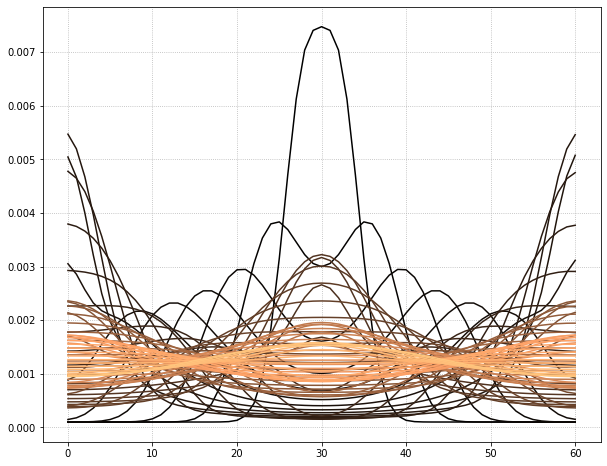

In [12]:
#--position of the source in the domain, generate a pulse
source_pos = [int(n_cell/2)]
pulse = numerical_scheme(n_gamma,dt,tf,source_pos,x,continuous=False)
fig(pulse,0)

### Double

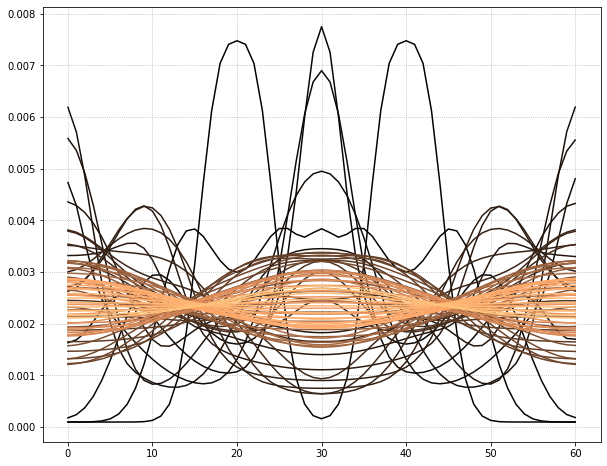

In [13]:
#--position of the source in the domain, generate two pulse
source_pos = [20,40]
double = numerical_scheme(n_gamma,dt,tf,source_pos,x,continuous=False)
fig(double,0)

### Packet

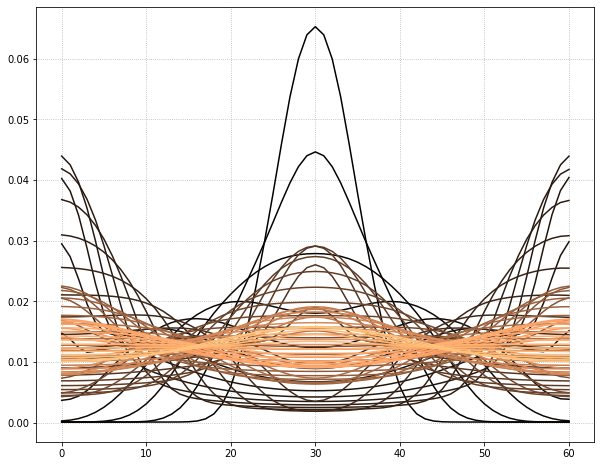

In [14]:
#--position of the source in the domain, generate 10 sources
source_pos = [25,26,27,28,29,30,31,32,33,34,35]
packet = numerical_scheme(n_gamma,dt,tf,source_pos,x,continuous=False)
fig(packet,0)

### Continuous

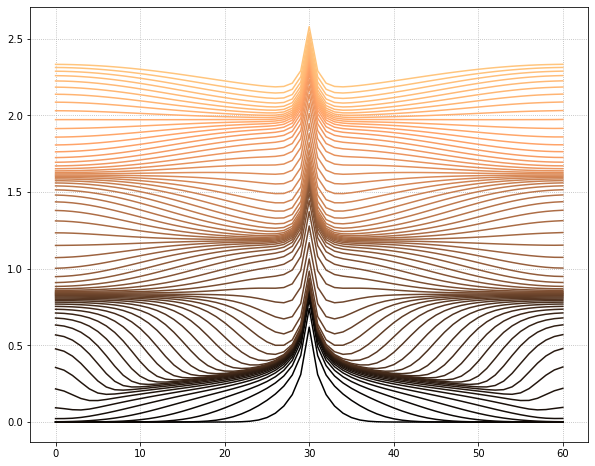

In [15]:
#--position of the source in the domain, generate a continuous source
source_pos = [int(n_cell/2)]
continuous = numerical_scheme(n_gamma,dt,tf,source_pos,x,continuous=True)
fig(continuous,0)

### Continuous with chemistry

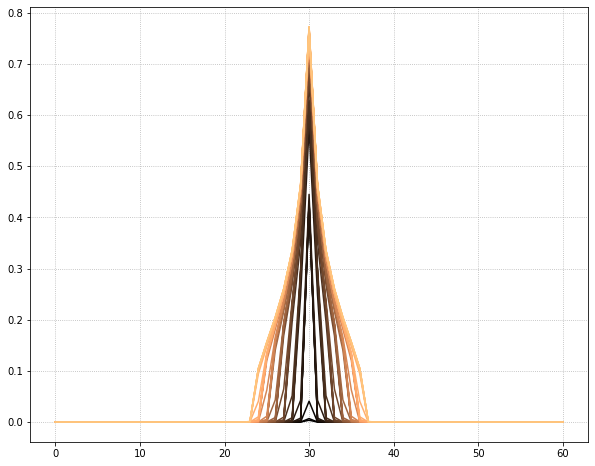

In [16]:
#--position of the source in the domain, generate a continuous source with chemistery
source_pos = [int(n_cell/2)]
continuous_chem = numerical_scheme(n_gamma,dt,tf,source_pos,x,continuous=True,chemistry=True)
fig(continuous_chem,0)